In this notebook I'll be testing model configurations to find out optimal batch_size/latency values for the encoder.

I will be testing cuda/cpu + fp16/amp/fp32, but not int8 as FBGEMM does not support transposed convolutions (yet).

In [1]:
!nvidia-smi -L

GPU 0: GeForce GTX 1080 Ti (UUID: GPU-80ea3a86-9161-af28-825a-3e8fccb01b72)


In [2]:
!head -20 /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 158
model name	: Intel(R) Core(TM) i5-8400 CPU @ 2.80GHz
stepping	: 10
microcode	: 0xde
cpu MHz		: 3446.669
cache size	: 9216 KB
physical id	: 0
siblings	: 6
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 22
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault invpcid_single pti ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid mpx rdseed adx smap clflushopt intel_pt xsaveopt xsavec xgetbv1 xsaves dthe

In [3]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          32061       10692       19536           5        1832       20961
Swap:          2047        2044           3


In [4]:
!pip3 install -q pandas matplotlib seaborn

In [5]:
import warnings; warnings.filterwarnings("ignore"); import os; os.environ['KALDI_ROOT'] = '/tmp' # ignore warnings

import gc
from pathlib import Path
import time

import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm

import boiler.dataset
import boiler.encoder

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
class args:
    wav_dir = Path('/home/proger/coub-crawler/monthlyLog/wav')
    pt_path = Path('/home/proger/boiler/exp/p_t64_b512/vqvae_223.pt')

In [8]:
torch.zeros(1).cuda() # warming up cuda

tensor([0.], device='cuda:0')

In [9]:
torch.cuda.memory_stats(0)['active.all.allocated']

10

In [10]:
memstats = torch.cuda.memory_stats(0)
memstats['allocated_bytes.all.current'], memstats['allocated_bytes.all.allocated']

(512, 5632)

In [11]:
torch.cuda.empty_cache()

In [12]:
golden_batch = next(iter(DataLoader(ConcatDataset([boiler.dataset.WavFile(wav) for wav in sorted(args.wav_dir.glob('*.wav'))]),
                                    batch_size=256, shuffle=True, num_workers=4)))

cpu_model = boiler.encoder.BagTopVQVAE(args.pt_path, device='cpu')
golden_embeddings = cpu_model.forward(golden_batch)

In [13]:
batch_sizes = {
    'cpu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 24, 32, 64],
    'cuda': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 24, 32, 64, 64+32, 128, 128+32, 128+64, 256, 512, 1024, 2048, 4096]
}

In [14]:
def device_type(model):
    return next(model.parameters()).device.type

def dtype(model):
    return next(model.parameters()).dtype

def size(model):
    return sum(p.numel() for p in model.parameters())

In [15]:
exps = []

In [16]:
models = [
    lambda: cpu_model,
    lambda: torch.jit.script(cpu_model),
    #lambda: cpu_model.half(), # these are generally very lossy
    #lambda: torch.jit.script(cpu_model.half()),
    lambda: boiler.encoder.BagTopVQVAE(args.pt_path, device='cuda'),
    lambda: torch.jit.script(boiler.encoder.BagTopVQVAE(args.pt_path, device='cuda')),
    #lambda: boiler.encoder.BagTopVQVAE(args.pt_path, device='cuda').half(),
    #lambda: torch.jit.script(boiler.encoder.BagTopVQVAE(args.pt_path, device='cuda').half()),
]

In [17]:
for mkmodel in tqdm(models):
    model = mkmodel()
    
    for autocast_enabled in (True, False):
        with torch.cuda.amp.autocast(autocast_enabled):

            for batch_size in batch_sizes[device_type(model)]:
                gc.collect()
                torch.cuda.empty_cache()

                repeat_dim = max(batch_size//golden_batch.size(0),1),1,1
                batch = golden_batch.repeat(*repeat_dim)[:batch_size]
                batch = batch.to(device_type(model)).type(dtype(model))

                loss_sample_batch_size = min(batch.size(0), golden_batch.size(0))

                try:
                    def run():
                        a = time.perf_counter()
                        results = model.forward(batch)
                        b = time.perf_counter()

                        loss = 1 - F.cosine_similarity(golden_embeddings[:loss_sample_batch_size],
                                                       results[:loss_sample_batch_size].cpu())
                        return b-a, loss.mean().item()

                    stats = torch.tensor([run() for _ in range(10)])
                    latency, loss = stats.mean(dim=0).tolist()
                    latency_std, loss_std = stats.std(dim=0).tolist()

                    exps.append(dict(batch_size=batch_size,
                                     latency=latency, latency_std=latency_std,
                                     loss=loss, loss_std=loss_std,
                                     device=device_type(model), dtype=dtype(model),
                                     type=type(model), size=size(model),
                                     autocast=autocast_enabled,
                                     reason='ok'))
                except RuntimeError as e:
                    exps.append(dict(batch_size=batch_size,
                                     latency=float('NaN'), latency_std=float('NaN'),
                                     loss=float('NaN'), loss_std=float('NaN'),
                                     device=device_type(model), dtype=dtype(model),
                                     type=type(model), size=size(model),
                                     autocast=autocast_enabled,
                                     reason=str(e)))
                finally:
                    del batch

100%|██████████| 4/4 [01:41<00:00, 25.34s/it]


In [18]:
df = pd.DataFrame(exps)
df

,batch_size,latency,latency_std,loss,loss_std,device,dtype,type,size,autocast,reason
0,1,0.020841,0.006813,0.0,0.0,cpu,torch.float32,<class 'boiler.encoder.BagTopVQVAE'>,10124865,True,ok
1,2,0.015706,0.000866,0.0,0.0,cpu,torch.float32,<class 'boiler.encoder.BagTopVQVAE'>,10124865,True,ok
2,3,0.018371,0.000500,0.0,0.0,cpu,torch.float32,<class 'boiler.encoder.BagTopVQVAE'>,10124865,True,ok
3,4,0.023156,0.000691,0.0,0.0,cpu,torch.float32,<class 'boiler.encoder.BagTopVQVAE'>,10124865,True,ok
4,5,0.029482,0.003985,0.0,0.0,cpu,torch.float32,<class 'boiler.encoder.BagTopVQVAE'>,10124865,True,ok
...,...,...,...,...,...,...,...,...,...,...,...
183,256,0.082841,0.000490,0.0,0.0,cuda,torch.float32,<class 'torch.jit._script.RecursiveScriptModule'>,10124865,False,ok
184,512,0.166913,0.000657,0.0,0.0,cuda,torch.float32,<class 'torch.jit._script.RecursiveScriptModule'>,10124865,False,ok
185,1024,0.330812,0.001962,0.0,0.0,cuda,torch.float32,<class 'torch.jit._script.RecursiveScriptModule'>,10124865,False,ok
186,2048,NaN,NaN,NaN,NaN,cuda,torch.float32,<class 'torch.jit._script.RecursiveScriptModule'>,10124865,False,The following operation failed in the TorchScr...


In [19]:
df.to_csv('benchmark-encoder.csv')

In [20]:
def suffix(s):
    return lambda x: s if x else ''

In [21]:
df['kind'] = df['device'] + '-' + df['dtype'].apply(repr) + df['type'].apply(repr).str.contains('jit').apply(suffix('-jit')) + df['autocast'].apply(suffix('-autocast')) + '-' + df['size'].apply(repr)

In [22]:
df['kind'] = df.kind.astype('category')

In [23]:
#df['sim'] = 50*((1-df.loss)**500)
df['sim'] = (1-df.loss)

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

(0, 0.021)

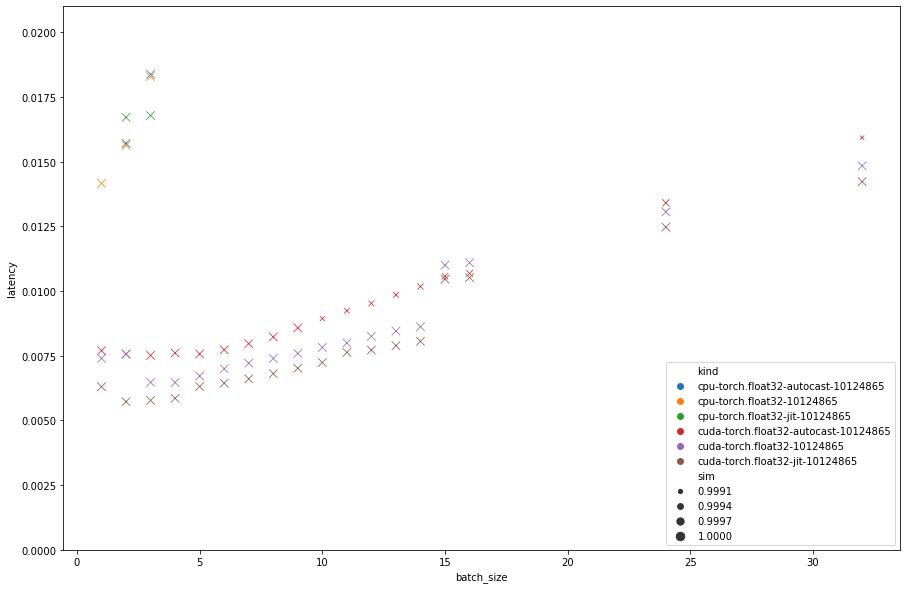

In [25]:
plt.figure(figsize=(15,10))
df = df.dropna()[df.latency<0.02]
sns.scatterplot(x=df.batch_size, y=df.latency, size=df.sim, marker='x', hue=df.kind)
plt.ylim(0, 0.021)

Looks like `batch_size` of 16 with a jit model without autocast (AMP) is a safe bet.